# Import package

In [2]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm, datasets
import pandas as pd
from sklearn import (metrics, cross_validation, linear_model, preprocessing)
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

# plt.style.use('fivethirtyeight')
sns.set(style = 'whitegrid',context = 'notebook')

# Import data

In [3]:
path='C:\\Users\\maint\\04-Finance\\FraudDetection.xlsx'
pdexcel = pd.ExcelFile(path)
FraudDetection_df = pdexcel.parse(pdexcel.sheet_names[0])

print (FraudDetection_df.shape)
FraudDetection_df.head()

(16281, 15)


,Transaction_ID,Card Tenure_months,WebsiteRegion,Trans_value,Seller_Category,Items_transaction,Shipping_Address,Purchase_Category,Othercard_owner,Seller_way,LastTransaction,Lastflagedvalue,LastMonthsTrans_Freq,Countryissuedcard,Fraud_Detected
0,1,25,US,256.41,Store + online,10,US,online services,Dependent,Yes,0,0,40,United-States,No
1,2,38,US,409.54,Online only,8,International,Accessories,Husband,Yes,0,0,50,United-States,No
2,3,28,EU,293.09,Online only,5,International,Electornics,Husband,Yes,0,0,40,United-States,Yes
3,4,44,US,444.07,Online only,7,International,online services,Husband,Yes,7688,0,40,United-States,Yes
4,5,18,EU,183.11,Online only,7,US,Food,Dependent,No,0,0,30,United-States,No


# Data Preparation

In [6]:
# Remove duplicated rows
FraudDetection_df = FraudDetection_df.drop_duplicates('Transaction_ID', keep='last')
print (FraudDetection_df.shape)

(16281, 15)


In [4]:
# Change name of target variable from 'Fraud_Detected' to 'target'
FraudDetection_df.rename(columns={'Fraud_Detected': 'target'}, inplace=True)
# Convert the target variable to binary column based on the 'target' to be 'Yes' and 'No'.
FraudDetection_df.loc[FraudDetection_df['target']=='Yes','target'] = 1
FraudDetection_df.loc[FraudDetection_df['target']=='No','target'] = 0
FraudDetection_df['target'] = FraudDetection_df['target'].astype(int) 

print (FraudDetection_df.shape)

(16281, 15)


In [12]:
# Create a sub-dataframe to store all numeric variables in the whole data frame
datatypes= ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numdf = FraudDetection_df.select_dtypes(include=datatypes)
# remove 'Transaction_ID' because it is not a predictor
numdf = numdf.drop(['Transaction_ID','target'],axis=1)

numerical_list = numdf.columns
print(numerical_list)
numdf.head()

Index(['Card Tenure_months', 'Trans_value', 'Items_transaction',
       'LastTransaction', 'Lastflagedvalue', 'LastMonthsTrans_Freq'],
      dtype='object')


,Card Tenure_months,Trans_value,Items_transaction,LastTransaction,Lastflagedvalue,LastMonthsTrans_Freq
0,25,256.41,10,0,0,40
1,38,409.54,8,0,0,50
2,28,293.09,5,0,0,40
3,44,444.07,7,7688,0,40
4,18,183.11,7,0,0,30


In [13]:
# Q21) Perform standardization for numerical variables
numdf = (numdf - numdf.min()) / (numdf.max() - numdf.min())
numdf.head()

,Card Tenure_months,Trans_value,Items_transaction,LastTransaction,Lastflagedvalue,LastMonthsTrans_Freq
0,0.109589,0.114366,0.600000,0.000000,0.0,0.397959
1,0.287671,0.317249,0.466667,0.000000,0.0,0.500000
2,0.150685,0.162964,0.266667,0.000000,0.0,0.397959
3,0.369863,0.362998,0.400000,0.076881,0.0,0.397959
4,0.013699,0.017250,0.400000,0.000000,0.0,0.295918


In [14]:
objtype = ['object']
objdf = FraudDetection_df.select_dtypes(include=objtype)

categorical_list = objdf.columns
print(categorical_list)
objdf.head()

Index(['WebsiteRegion', 'Seller_Category', 'Shipping_Address',
       'Purchase_Category', 'Othercard_owner', 'Seller_way',
       'Countryissuedcard'],
      dtype='object')


,WebsiteRegion,Seller_Category,Shipping_Address,Purchase_Category,Othercard_owner,Seller_way,Countryissuedcard
0,US,Store + online,US,online services,Dependent,Yes,United-States
1,US,Online only,International,Accessories,Husband,Yes,United-States
2,EU,Online only,International,Electornics,Husband,Yes,United-States
3,US,Online only,International,online services,Husband,Yes,United-States
4,EU,Online only,US,Food,Dependent,No,United-States


In [15]:
# Q5) Create another copy of the data frame
fdall = FraudDetection_df.copy()

In [16]:
objtype = ['object']
objdf = fdall.select_dtypes(include=objtype)

objdf['WebsiteRegion']=objdf.WebsiteRegion + "_WE1"
objdf['Seller_Category']=objdf.Seller_Category + "_SC2"
objdf['Shipping_Address']=objdf.Shipping_Address + "_SA3"
objdf['Purchase_Category']=objdf.Purchase_Category +"_PC4"
objdf['Othercard_owner']=objdf.Othercard_owner+"_OO5"
objdf['Seller_way']=objdf.Seller_way +"_SW6"
objdf['Countryissuedcard']=objdf.Countryissuedcard +"_CO7"

objdf_new=pd.DataFrame([])
objdf.head()

,WebsiteRegion,Seller_Category,Shipping_Address,Purchase_Category,Othercard_owner,Seller_way,Countryissuedcard
0,US_WE1,Store + online_SC2,US_SA3,online services_PC4,Dependent_OO5,Yes_SW6,United-States_CO7
1,US_WE1,Online only_SC2,International_SA3,Accessories_PC4,Husband_OO5,Yes_SW6,United-States_CO7
2,EU_WE1,Online only_SC2,International_SA3,Electornics_PC4,Husband_OO5,Yes_SW6,United-States_CO7
3,US_WE1,Online only_SC2,International_SA3,online services_PC4,Husband_OO5,Yes_SW6,United-States_CO7
4,EU_WE1,Online only_SC2,US_SA3,Food_PC4,Dependent_OO5,No_SW6,United-States_CO7


In [18]:
catpredictor=list(objdf.columns)
for cat in catpredictor:
        print ('original var name: ', cat.encode("utf-8"))
        varname=cat
        df_temp = pd.get_dummies(objdf[varname])
        objdf_new = pd.concat([objdf_new, df_temp], axis=1)

print ('dummy names:', list(objdf_new.columns))
print ('# of dummies:', len(list(objdf_new.columns)))
print ('shape:', objdf_new.shape)
objdf_new.head()

original var name:  b'WebsiteRegion'
original var name:  b'Seller_Category'
original var name:  b'Shipping_Address'
original var name:  b'Purchase_Category'
original var name:  b'Othercard_owner'
original var name:  b'Seller_way'
original var name:  b'Countryissuedcard'
dummy names: ['EU_WE1', 'Eastern Europe_WE1', 'US_WE1', 'Unclassified_WE1', 'Online only_SC2', 'Store + online_SC2', 'Canada_SA3', 'International_SA3', 'US_SA3', 'Accessories_PC4', 'Books_PC4', 'Electornics_PC4', 'Food_PC4', 'Paying bills_PC4', 'Tickets - flights_PC4', 'online services_PC4', 'Dependent_OO5', 'Husband_OO5', 'None_OO5', 'Wife_OO5', 'No_SW6', 'Yes_SW6', 'Other_CO7', 'United-States_CO7']
# of dummies: 24
shape: (16281, 24)


,EU_WE1,Eastern Europe_WE1,US_WE1,Unclassified_WE1,Online only_SC2,Store + online_SC2,Canada_SA3,International_SA3,US_SA3,Accessories_PC4,...,Tickets - flights_PC4,online services_PC4,Dependent_OO5,Husband_OO5,None_OO5,Wife_OO5,No_SW6,Yes_SW6,Other_CO7,United-States_CO7
0,0,0,1,0,0,1,0,0,1,0,...,0,1,1,0,0,0,0,1,0,1
1,0,0,1,0,1,0,0,1,0,1,...,0,0,0,1,0,0,0,1,0,1
2,1,0,0,0,1,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,1
3,0,0,1,0,1,0,0,1,0,0,...,0,1,0,1,0,0,0,1,0,1
4,1,0,0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,1


In [19]:
X = pd.concat([numdf , objdf_new], axis=1)
print (X.shape)
Y = fdall['target']
print (Y.shape)

(16281, 30)
(16281,)


# Feature Selection

### Filter

#### Pearson Correlation

In [23]:
def cor_selector(X, y):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature

In [24]:
cor_support, cor_feature = cor_selector(X, Y)
print(str(len(cor_feature)), 'selected features')

30 selected features


In [58]:
cor_list = []
feature_name = X.columns.tolist()

for i in X.columns.tolist():
    cor = np.corrcoef(X[i], Y)[0, 1]
    cor_list.append(cor)
cor_list = [0 if np.isnan(i) else i for i in cor_list]
cor_list = np.round(np.abs(cor_list),3)

In [59]:
#get feature importances from the model
headers = ["name", "score"]
values = sorted(zip(feature_name, cor_list), key=lambda x: x[1] * -1)
feature_importances = pd.DataFrame(values, columns = headers)

In [60]:
feature_importances

,name,score
0,International_SA3,0.448
1,Husband_OO5,0.409
2,US_SA3,0.398
3,Items_transaction,0.327
4,None_OO5,0.297
5,LastMonthsTrans_Freq,0.224
6,Card Tenure_months,0.223
7,Trans_value,0.223
8,LastTransaction,0.222
9,Dependent_OO5,0.220


#### Chi-2

In [74]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=10)
chi_selector.fit(X_norm, Y)

SelectKBest(k=10, score_func=<function chi2 at 0x000001CC326EA9D8>)

In [84]:
# check which one is selected
chi_support = chi_selector.get_support(indices=False)
chi_support

array([False, False, False,  True, False, False, False, False, False,
       False, False, False, False,  True,  True, False,  True,  True,
       False, False, False,  True,  True,  True,  True, False,  True,
       False, False, False], dtype=bool)

In [86]:
chi_selector.get_support(indices=True)

array([ 3, 13, 14, 16, 17, 21, 22, 23, 24, 26], dtype=int64)

In [85]:
chi_feature = X.loc[:,chi_support].columns.tolist()
chi_feature

['LastTransaction',
 'International_SA3',
 'US_SA3',
 'Books_PC4',
 'Electornics_PC4',
 'online services_PC4',
 'Dependent_OO5',
 'Husband_OO5',
 'None_OO5',
 'No_SW6']

In [88]:
X.columns.tolist()

['Card Tenure_months',
 'Trans_value',
 'Items_transaction',
 'LastTransaction',
 'Lastflagedvalue',
 'LastMonthsTrans_Freq',
 'EU_WE1',
 'Eastern Europe_WE1',
 'US_WE1',
 'Unclassified_WE1',
 'Online only_SC2',
 'Store + online_SC2',
 'Canada_SA3',
 'International_SA3',
 'US_SA3',
 'Accessories_PC4',
 'Books_PC4',
 'Electornics_PC4',
 'Food_PC4',
 'Paying bills_PC4',
 'Tickets - flights_PC4',
 'online services_PC4',
 'Dependent_OO5',
 'Husband_OO5',
 'None_OO5',
 'Wife_OO5',
 'No_SW6',
 'Yes_SW6',
 'Other_CO7',
 'United-States_CO7']

In [89]:
chi_selector.scores_

array([  9.79412778e+01,   8.86537883e+01,   1.29459108e+02,
         4.28420233e+02,   1.60046269e+02,   3.28662048e+01,
         2.26348825e+01,   4.26001517e+01,   9.46613315e-01,
         7.03408986e+00,   5.93474104e+01,   2.85490273e+02,
         1.50636274e+02,   1.78124067e+03,   1.34071643e+03,
         6.53140757e+01,   5.87740251e+02,   5.02366396e+02,
         2.08761969e+02,   1.10190105e+01,   2.38479005e+00,
         4.21378550e+02,   6.66294048e+02,   1.63483055e+03,
         8.64010844e+02,   2.04435363e+02,   4.87594718e+02,
         2.43393275e+02,   1.20995420e+01,   1.33604955e+00])

In [90]:
# Variable Importance
feature_list = X.columns
# Get numerical feature importance
importance_list = list(chi_selector.scores_)
# p value
pvalue_list = list(chi_selector.pvalues_)
# List of tuples with variable and importance
feature_importances = [(feature, np.abs(round(importance, 2)),pvalue) for feature, importance, pvalue in zip(feature_labels, importances, pvalues)]

In [92]:
#get feature importances from the model
headers = ["name", "score", "pvalue"]
# values = sorted(zip(feature_list, cor_list, pvalue_list), key=lambda x: x[1] * -1)
values = sorted(zip(feature_list, cor_list, pvalue_list))
values = sorted(values, key = lambda x: x[1], reverse = True)
feature_importances = pd.DataFrame(values, columns = headers)
feature_importances

,name,score,pvalue
0,International_SA3,0.448,0.000000e+00
1,Husband_OO5,0.409,0.000000e+00
2,US_SA3,0.398,1.603524e-293
3,Items_transaction,0.327,5.381376e-30
4,None_OO5,0.297,6.540462e-190
5,LastMonthsTrans_Freq,0.224,9.872468e-09
6,Card Tenure_months,0.223,4.309755e-23
7,Trans_value,0.223,4.703251e-21
8,LastTransaction,0.222,3.586952e-95
9,Dependent_OO5,0.220,6.390629e-147


### Wrapper

In [94]:
strat_k_fold = 10
# Feature Selection
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg_model = LogisticRegression()
rfecv = RFECV(estimator=logreg_model, step=1, cv=strat_k_fold, scoring='accuracy')
rfecv.fit(X, Y)

RFECV(cv=10,
   estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
   n_jobs=1, scoring='accuracy', step=1, verbose=0)

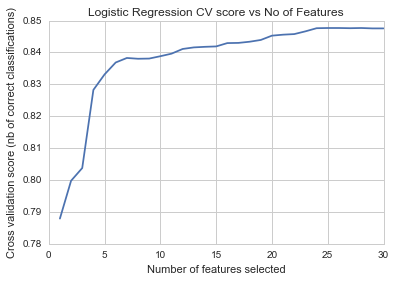

In [95]:
# plot grid_scores_
plt.figure()
plt.title('Logistic Regression CV score vs No of Features')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

In [103]:
feature_importance = list(zip(X.columns, rfecv.support_))
new_features = []
for key,value in enumerate(feature_importance):
    if(value[1]) == True:
        new_features.append(value[0])        
print(new_features)

['Card Tenure_months', 'Trans_value', 'Items_transaction', 'LastTransaction', 'Lastflagedvalue', 'LastMonthsTrans_Freq', 'EU_WE1', 'Unclassified_WE1', 'Online only_SC2', 'Store + online_SC2', 'Canada_SA3', 'International_SA3', 'US_SA3', 'Accessories_PC4', 'Books_PC4', 'Electornics_PC4', 'Food_PC4', 'Tickets - flights_PC4', 'online services_PC4', 'Dependent_OO5', 'None_OO5', 'Wife_OO5', 'No_SW6', 'Yes_SW6', 'Other_CO7', 'United-States_CO7']


In [100]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=10, step=10, verbose=5)
rfe_selector.fit(X_norm, Y)

Fitting estimator with 30 features.
Fitting estimator with 20 features.


RFE(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
  n_features_to_select=10, step=10, verbose=5)

In [101]:
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

10 selected features


In [102]:
rfe_feature

['Card Tenure_months',
 'Trans_value',
 'Items_transaction',
 'LastTransaction',
 'Lastflagedvalue',
 'LastMonthsTrans_Freq',
 'Canada_SA3',
 'International_SA3',
 'US_SA3',
 'Dependent_OO5']

# Embeded

#### LogisticRegression

In [105]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l1"), '1.25*median')
embeded_lr_selector.fit(X_norm, Y)



embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

13 selected features


#### Random Forest

In [107]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), threshold='1.25*median')
embeded_rf_selector.fit(X, Y)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
        norm_order=1, prefit=False, threshold='1.25*median')

In [111]:
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print(embeded_rf_feature)
print(str(len(embeded_rf_feature)), 'selected features')

['Card Tenure_months', 'Trans_value', 'Items_transaction', 'LastTransaction', 'Lastflagedvalue', 'LastMonthsTrans_Freq', 'International_SA3', 'US_SA3', 'Books_PC4', 'Electornics_PC4', 'Husband_OO5', 'None_OO5']
12 selected features


#### LightGBM

In [112]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier

lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

embeded_lgb_selector = SelectFromModel(lgbc, threshold='1.25*median')
embeded_lgb_selector.fit(X, Y)

ModuleNotFoundError: No module named 'lightgbm'

In [113]:
pd.set_option('display.max_rows', None)
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support, 'Logistics':embeded_lr_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(100)

,Chi-2,Feature,Logistics,Pearson,RFE,Random Forest,Total
1,True,US_SA3,True,True,True,True,5
2,True,LastTransaction,True,True,True,True,5
3,False,Trans_value,True,True,True,True,4
4,False,Lastflagedvalue,True,True,True,True,4
5,False,LastMonthsTrans_Freq,True,True,True,True,4
6,False,Items_transaction,True,True,True,True,4
7,True,International_SA3,False,True,True,True,4
8,True,Dependent_OO5,True,True,True,False,4
9,False,Card Tenure_months,True,True,True,True,4
10,True,Books_PC4,True,True,False,True,4
